C:\Users\oness\AppData\Roaming\Python\Python313\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\oness\AppData\Local\Temp\ipykernel_16960\1446809780.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates_df = df.groupby('subject#').apply(lambda x: (x['total_UPDRS'].max() - x['total_UPDRS'].min()) / (x['test_time'].max() - x['test_time'].min()) if (x['test_time'].max() - x['test_time'].min()) > 0 else 0).reset_index(name='rate')



--- Analysis Report ---
Input Data: [22, 25, 26, 29, 32]
Context: Age≈65, Sex=Male
-------------------------
Predicted Cohort: Fast Progressor (AI-Discovered)
Closest Match: Patient #13
Match Confidence: 71.5%
-------------------------


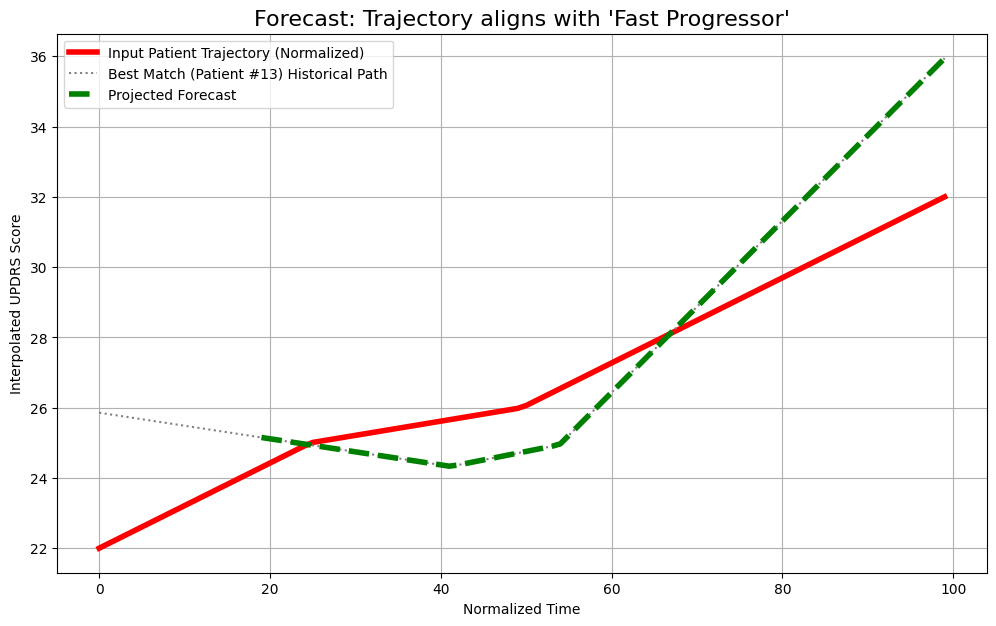

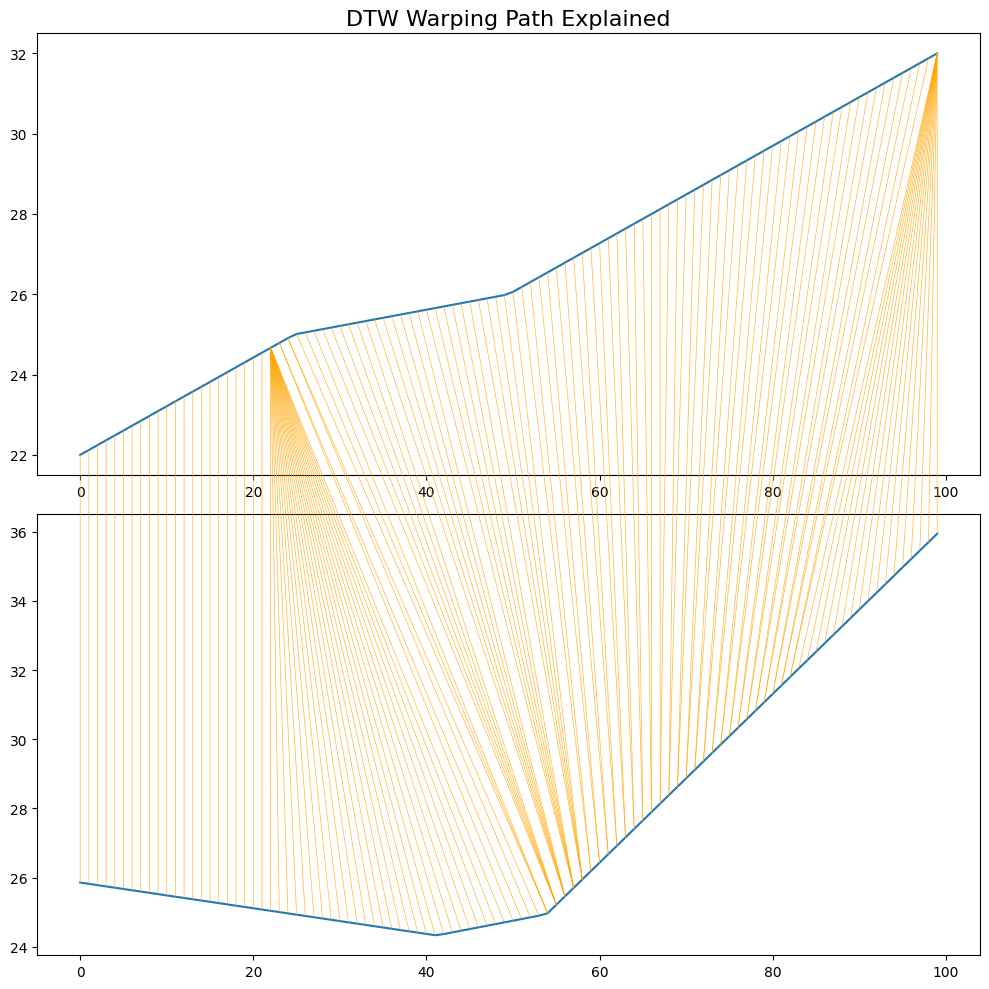

In [5]:
# PARKINSON'S SYMPTOM PROGRESSION ANALYZER - ANALYSIS ENGINE
# Author: Onessa Crispeyn
#
# Description:
# This script contains the core data analysis and machine learning pipeline for the
# analysing the progression of Parkinson's Disease. It loads raw clinical data, discovers
# patient cohorts using unsupervised learning, and provides a context-aware engine
# for classifying and forecasting new patient trajectories.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from dtaidistance import dtw, dtw_visualisation


column_names = [
    'subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)',
    'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
    'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
]

df = pd.read_csv('./parkinsons_updrs.data', names=column_names)
df = df[['subject#', 'age', 'sex', 'test_time', 'total_UPDRS']]

# Ensure key columns are numeric and remove any rows with missing essential data.
df[['total_UPDRS', 'test_time', 'age']] = df[['total_UPDRS', 'test_time', 'age']].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)


# Prepares the unevenly spaced time-series data for analysis.
def normalize_and_interpolate(patient_df, points=100):
    """
    Standardizes a patient's time-series data to a fixed length of 100 points.

    This involves normalising the time axis from 0 to 1 and then using linear
    interpolation to create an evenly spaced representation of the trajectory,
    making different patients directly comparable.

    Args:
        patient_df (pd.DataFrame): DataFrame for a single patient.
        points (int): The number of points for the standardized trajectory.

    Returns:
        np.array: A 100-point NumPy array representing the interpolated trajectory, or None if invalid.
    """
    if len(patient_df) < 2: return None
    min_time = patient_df['test_time'].min()
    max_time = patient_df['test_time'].max()
    if max_time == min_time: return None
    
    time_normalized = (patient_df['test_time'] - min_time) / (max_time - min_time)
    
    interp_func = interp1d(time_normalized, patient_df['total_UPDRS'], kind='linear', fill_value="extrapolate")
    
    return interp_func(np.linspace(0, 1, points))

# Dictionary of all valid, standardized patient trajectories.
all_trajectories = {sid: normalize_and_interpolate(pdf) for sid, pdf in df.groupby('subject#') if normalize_and_interpolate(pdf) is not None}
subject_ids = list(all_trajectories.keys())
trajectory_matrix = np.array(list(all_trajectories.values()))

# Filter out any trajectories that may have resulted in NaN values after interpolation.
nan_rows_mask = np.isnan(trajectory_matrix).any(axis=1)
if np.any(nan_rows_mask):
    trajectory_matrix = trajectory_matrix[~nan_rows_mask]
    subject_ids = [sid for i, sid in enumerate(subject_ids) if not nan_rows_mask[i]]


# Use K-Means clustering to discover the natural patient archetypes in the data.
# This is an unsupervised approach, meaning the model finds patterns without predefined labels.
scaler = StandardScaler()
scaled_trajectories = scaler.fit_transform(trajectory_matrix)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_trajectories)

# Associate the discovered cluster labels back to the patient IDs.
cohort_df = pd.DataFrame({'subject#': subject_ids, 'cluster': clusters})

# Determine which cluster represents "Fast" vs. "Slow" progression by calculating the
# average real-world progression rate for each cluster and assigning labels accordingly.
rates_df = df.groupby('subject#').apply(lambda x: (x['total_UPDRS'].max() - x['total_UPDRS'].min()) / (x['test_time'].max() - x['test_time'].min()) if (x['test_time'].max() - x['test_time'].min()) > 0 else 0).reset_index(name='rate')
cohort_df = pd.merge(cohort_df, rates_df, on='subject#')
cluster_avg_rates = cohort_df.groupby('cluster')['rate'].mean()
fast_cluster_id = cluster_avg_rates.idxmax()
cohort_df['cohort'] = np.where(cohort_df['cluster'] == fast_cluster_id, 'Fast Progressor (AI-Discovered)', 'Slow Progressor (AI-Discovered)')

# Merge the final cohort labels back into the main DataFrame for use by the engine.
df = pd.merge(df, cohort_df[['subject#', 'cohort']], on='subject#')


# Matching and Forecasting Engine
# This engine takes a new patient's UPDRS trajectory and finds the best historical match
# using Dynamic Time Warping (DTW). It can also incorporate patient context like age and sex.
def find_best_match(new_patient_series, patient_age=None, patient_sex=None, age_window=5):
    """
    Finds the best historical match for a new patient's trajectory using DTW.

    Args:
        new_patient_series (list): A list of UPDRS scores for the new patient.
        patient_age (int, optional): Patient's age for contextual filtering.
        patient_sex (int, optional): Patient's sex (0=male, 1=female) for filtering.
        age_window (int, optional): The +/- range for age-based filtering.

    Returns:
        dict: A dictionary containing the analysis results, or None if no match is found.
    """
    new_patient_interpolated = normalize_and_interpolate(pd.DataFrame({'test_time': range(len(new_patient_series)), 'total_UPDRS': new_patient_series}))
    
    # Contextual Filtering: Narrow down the search space based on patient demographics.
    target_df = df.copy()
    context_applied = False
    if patient_age is not None and patient_sex is not None:
        filtered_df = df[df['age'].between(patient_age - age_window, patient_age + age_window) & (df['sex'] == patient_sex)]
        if len(filtered_df) >= 5:
            target_df = filtered_df
            context_applied = True
        
    min_dist, best_match_id, best_match_cohort, best_match_path, best_match_trajectory = float('inf'), None, None, None, None

    # Find the single best match from the target group using DTW.
    for sid in target_df['subject#'].unique():
        if sid in all_trajectories:
            traj = all_trajectories[sid]
            dist = dtw.distance(new_patient_interpolated, traj)
            if dist < min_dist:
                min_dist = dist
                best_match_id = sid
                best_match_cohort = target_df[target_df['subject#'] == sid]['cohort'].iloc[0]
                best_match_path = dtw.warping_path(new_patient_interpolated, traj)
                best_match_trajectory = traj
    
    if best_match_id is None: return None
    
    # Calculate a statistical confidence score for the match.
    cohort_ids = target_df[target_df['cohort'] == best_match_cohort]['subject#'].unique()
    cohort_distances = [dtw.distance(best_match_trajectory, all_trajectories[sid]) for sid in cohort_ids if sid != best_match_id and sid in all_trajectories]
    median_cohort_dist = np.median(cohort_distances) if cohort_distances else min_dist
    confidence = max(0, 100 * (1 - min_dist / (median_cohort_dist + 1e-6)))

    return {
        "cohort": best_match_cohort, "match_id": best_match_id, "confidence": confidence, "path": best_match_path,
        "new_patient_interp": new_patient_interpolated, "match_trajectory_interp": best_match_trajectory,
        "context_applied": context_applied
    }


# Demonstrates how to use the find_best_match function and visualize its output.
if __name__ == '__main__':
    # Define a sample patient for testing the engine
    test_patient_data = [22, 25, 26, 29, 32]
    # Run the analysis
    results = find_best_match(test_patient_data, patient_age=65, patient_sex=0)

    if results:
        # Print a clear summary report to the console
        print("\n--- Analysis Report ---")
        print(f"Input Data: {test_patient_data}")
        print(f"Context: Age≈65, Sex=Male")
        print("-------------------------")
        print(f"Predicted Cohort: {results['cohort']}")
        print(f"Closest Match: Patient #{results['match_id']}")
        print(f"Match Confidence: {results['confidence']:.1f}%")
        print("-------------------------")

        # Generate and display the Predictive Forecast Visualization
        fig1, ax1 = plt.subplots(figsize=(12, 7))
        cutoff_point = 20
        matched_trajectory = results['match_trajectory_interp']
        x_full, x_forecast = np.arange(100), np.arange(cutoff_point - 1, 100)
        ax1.plot(results['new_patient_interp'], label='Input Patient Trajectory (Normalized)', color='red', linewidth=4)
        ax1.plot(x_full, matched_trajectory, label=f'Best Match (Patient #{results["match_id"]}) Historical Path', color='gray', linestyle=':')
        ax1.plot(x_forecast, matched_trajectory[cutoff_point - 1:], color='green', linewidth=4, linestyle='--', label='Projected Forecast')
        title = f"Forecast: Trajectory aligns with '{results['cohort'].split('(')[0].strip()}'"
        ax1.set_title(title, fontsize=16)
        ax1.set_xlabel('Normalized Time')
        ax1.set_ylabel('Interpolated UPDRS Score')
        ax1.legend()
        ax1.grid(True)
        plt.show()

        # Generate and display the Explainable AI (XAI) Visualisation
        fig2, (ax2_1, ax2_2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
        dtw_visualisation.plot_warping(results['new_patient_interp'], results['match_trajectory_interp'], results['path'], fig=fig2, axs=(ax2_1, ax2_2))
        ax2_1.set_title("DTW Warping Path Explained", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not find a suitable match for the test patient based on the specified context.")